In [73]:
# from skimage.util.montage import montage2d
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import skimage
import numpy as np
import time
import os

from skimage import measure

from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull

In [3]:
print(skimage.__version__)

0.13.0


In [3]:
home = os.path.expanduser('~')
directory = os.path.join('Datasets', 'ImageCLEF')
filename = '4231cdb3-af46-4674-be08-95b904a62093_TrainSet_metaData.csv'
path = os.path.join(home, directory, filename)

# df = pd.read_csv(path)
# df.head(10)

In [119]:
img_depth = 84

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume, min, max):
    """Normalize the volume"""
    
    level = 250
    window = 50
#     max = int(level+ (window/2))
#     min = int(level- (window/2))
    
#     min = -800
#     max = -300
#     volume[volume < min] = min
#     volume[volume > max] = max
    volume = volume.clip(min, max)

#     volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    '''
    
    level = 1000
    window = 250
    max = level+ (window/2)
    max = level- (window/2)
    
    volume = volume.clip(min, max)
    volume = volume.astype("float32")
    '''
    
    return volume
'''
def intensity_seg(ct_numpy, min=-1000, max=-300):
    clipped = clip_ct(ct_numpy, min, max)
    return measure.find_contours(ct_numpy, 0.95)
'''    
def intensity_seg(ct_numpy, min=-1000, max=-300):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)
    
def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False
    
def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    First, we exclude non-closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs
    Args:
        contours: all the detected contours
    Returns: contours that correspond to the lung area
    """
    body_and_lung_contours = []
    vol_contours = []
    for contour in contours:
        hull = ConvexHull(contour)
       # set some constraints for the volume
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)
    # Discard body contour
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in 
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1) # body is out!
    return body_and_lung_contours # only lungs left !!!

def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours
    Returns:
    """
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask
    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return lung_mask.T  # transpose it to be aligned with the image dims

def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -600] = 1
    vessels[vessels < -600] = 0
#     show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
#     show_slice(vessels)
    return vessels

def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels

def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    
#     print(f"Shape: {img.shape}")
    desired_depth = img_depth
    desired_width = 512
    desired_height = 512
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    
#     img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()

def process_scan(path, min=-1000, max=-150):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    
    print(path)
    print(volume.shape)
    
    slices = volume.shape[-1]
    sl_min = int((2/9) * slices + (14/9))
    sl_max = int((7/54) * slices + (49/54))
    
    volume = volume[:, :, sl_min:-sl_max]
    
    volume = np.mean(volume, axis=2)
#     volume = normalize(volume, min, max)
    
    print(f'Min {sl_min}\tMax {sl_max}')
    
    contour = intensity_seg(volume, min=-1000, max=-300)
    contour = find_lungs(contour)
    
    mask = create_mask_from_polygon(volume, contour)
    
    vessels = create_vessel_mask(mask, volume, lungs_contour=contour, denoise=False)
    
    
    
#     return 
    # Normalize
    
    


    # Resize width, height and depth
#     volume = resize_volume(volume)
    return volume

def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

In [5]:
dataset_dir = os.path.join(home, directory, 'Dataset')

/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0066.nii.gz
(512, 512, 130)
Min 30	Max 17


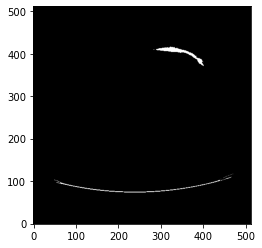

In [104]:


'''
figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1, 3, 1)
ax2 = figure.add_subplot(1, 3, 2)
ax3 = figure.add_subplot(1, 3, 3)

# ax1.imshow(image1, cmap='gray')
# ax2.imshow(image2, cmap='gray')
# ax3.imshow(image3, cmap='gray')
'''

volume = process_scan(os.path.join(dataset_dir, 'TRN_0066.nii.gz'))
# image2 = process_scan(os.path.join(dataset_dir, 'TRN_0008.nii.gz'))
# image3 = process_scan(os.path.join(dataset_dir, 'TRN_0011.nii.gz'))

# overlay_plot(volume, vessels)

/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0068.nii.gz
(512, 512, 263)
Min 60	Max 34
/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0068.nii.gz
(512, 512, 263)
Min 60	Max 34
/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0068.nii.gz
(512, 512, 263)
Min 60	Max 34


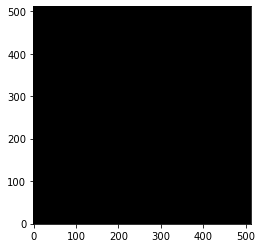

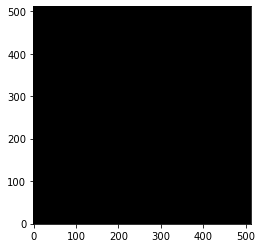

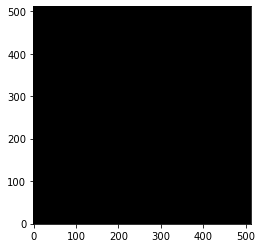

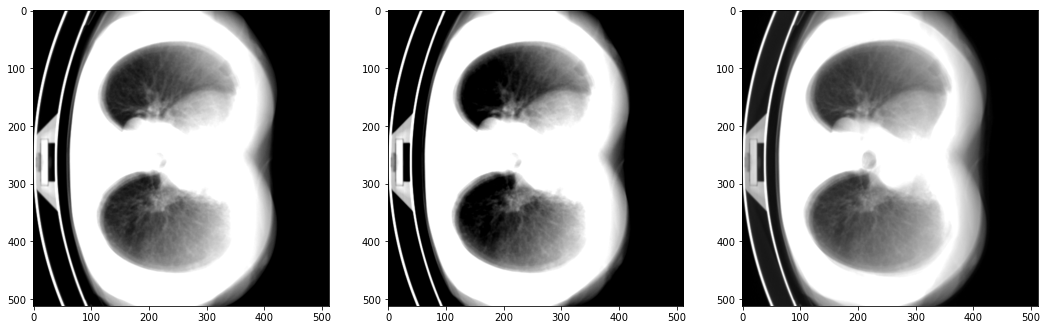

In [99]:
%matplotlib inline

image4 = process_scan(os.path.join(dataset_dir, 'TRN_0068.nii.gz'), -900, -300)
image5 = process_scan(os.path.join(dataset_dir, 'TRN_0068.nii.gz'), -800, -300)
image6 = process_scan(os.path.join(dataset_dir, 'TRN_0068.nii.gz'), -1000, -150)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1, 3, 1)
ax2 = figure.add_subplot(1, 3, 2)
ax3 = figure.add_subplot(1, 3, 3)

ax1.imshow(image4, cmap='gray')
ax2.imshow(image5, cmap='gray')
ax3.imshow(image6, cmap='gray')

In [140]:
#     img_name = exam_path.split("/")[-1].split('.nii')[0]
#     vessel_name = vessels + img_name + "_vessel_only_mask"
#     overlay_name = overlay_path + img_name + "_vessels"

def get_mean_mask(img_name):
    ct_img = nib.load(os.path.join(dataset_dir, img_name))
#     pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    volume = ct_numpy

    slices = volume.shape[-1]
    sl_min = int((2/9) * slices + (14/9))
    sl_max = int((7/54) * slices + (49/54))
    
    volume = volume[:, :, sl_min:-sl_max]
    
# volume = np.mean(volume, axis=2)

    slices_arr = []

    for i in range(volume.shape[2]):
        slice_i = volume[:, :, i]
    
        contours = intensity_seg(slice_i, -1000, -300)

        lungs_contour = find_lungs(contours)
        lung_mask = create_mask_from_polygon(slice_i, lungs_contour)

        vessels_only = create_vessel_mask(lung_mask, slice_i, denoise=False)
    
        slices_arr.append(vessels_only)
    
    slices_arr = np.array(slices_arr)
    slices_arr_mean = np.mean(slices_arr, axis=0)

    slices_arr_mean[slices_arr_mean < 0.033] = 0.033
    slices_arr_mean[slices_arr_mean > 0.20] = 0.20
    
    return slices_arr_mean
#     plt.imshow(slices_arr_mean, cmap='gray')

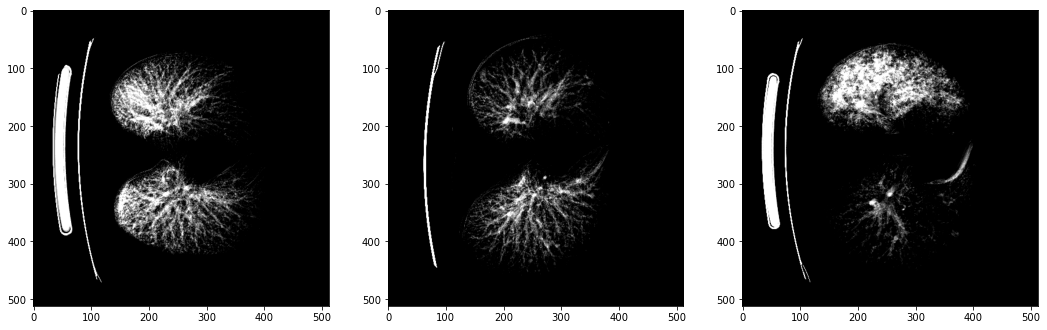

In [141]:
mask_mean1 = get_mean_mask('TRN_0077.nii.gz')
mask_mean2 = get_mean_mask('TRN_0073.nii.gz')
mask_mean3 = get_mean_mask('TRN_0066.nii.gz')

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1, 3, 1)
ax2 = figure.add_subplot(1, 3, 2)
ax3 = figure.add_subplot(1, 3, 3)

ax1.imshow(mask_mean1, cmap='gray')
ax2.imshow(mask_mean2, cmap='gray')
ax3.imshow(mask_mean3, cmap='gray')

In [124]:
print(np.mean(slices_arr_mean))
print(np.max(slices_arr_mean))
print(np.min(slices_arr_mean))

0.03998413085937501
0.8615384615384616
0.0


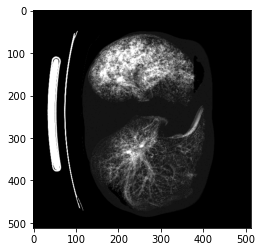

In [130]:
new_slices_arr_mean = np.copy(slices_arr_mean)
new_slices_arr_mean[new_slices_arr_mean < 0.033] = 0.033
new_slices_arr_mean[new_slices_arr_mean > 0.20] = 0.20
plt.imshow(new_slices_arr_mean, cmap='gray')

/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0068.nii.gz
(512, 512, 263)
Min 60	Max 34
/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0166.nii.gz
(512, 512, 47)
Min 12	Max 7
/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0077.nii.gz
(512, 512, 115)
Min 27	Max 15


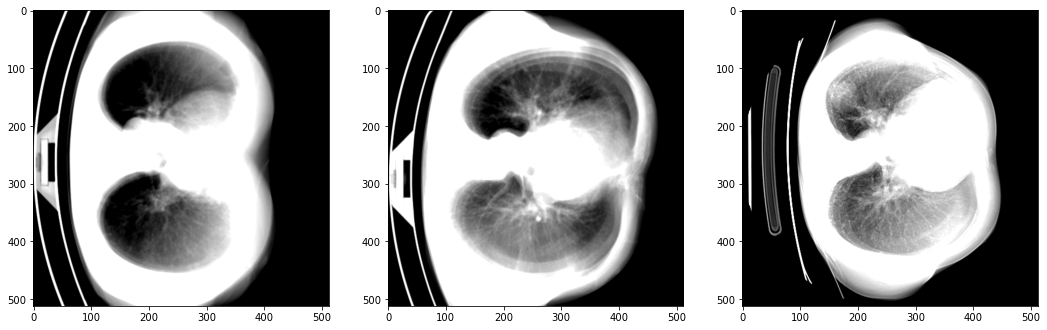

In [58]:
%matplotlib inline

image4 = process_scan(os.path.join(dataset_dir, 'TRN_0068.nii.gz'))
image5 = process_scan(os.path.join(dataset_dir, 'TRN_0166.nii.gz'))
image6 = process_scan(os.path.join(dataset_dir, 'TRN_0077.nii.gz'))

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1, 3, 1)
ax2 = figure.add_subplot(1, 3, 2)
ax3 = figure.add_subplot(1, 3, 3)

ax1.imshow(image4, cmap='gray')
ax2.imshow(image5, cmap='gray')
ax3.imshow(image6, cmap='gray')

/home/ayushman.singh/Datasets/ImageCLEF/Dataset/TRN_0166.nii.gz
(512, 512, 47)


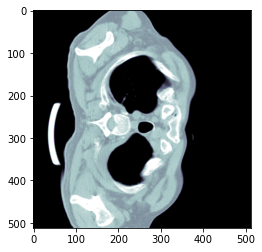

In [45]:
# import matplotlib as mp

# test_image = process_scan(os.path.join(dataset_dir, 'TRN_0062.nii.gz'))
test_image = process_scan(os.path.join(dataset_dir, 'TRN_0166.nii.gz'))

plt.imshow(test_image[:, :, 40], cmap='gray')
# ax1.imshow(montage2d(test_image), cmap ='bone')
# fig.savefig('ct_scan.png')

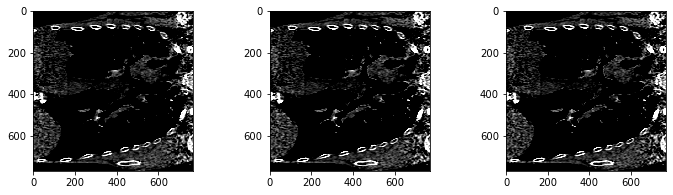

In [52]:
%matplotlib inline

img_path = os.path.join(directory, 'Dataset', 'TRN_0066.nii.gz')
# slice = 253

image_vol = nib.load(img_path)
vol_arr = image_vol.get_fdata()

dims = (768, 768)

slice_resized = cv2.resize(image_slice, 
                           dims, 
                           interpolation=cv2.INTER_AREA)

slice_resized2 = cv2.resize(image_slice, 
                           dims, 
                           interpolation=cv2.INTER_CUBIC)
# cv2.imshow(slice_resized)

slice_resized3 = cv2.resize(image_slice, 
                           dims, 
                           interpolation=cv2.INTER_LANCZOS4)


figure = plt.figure(figsize=(12, 10))
ax1 = figure.add_subplot(3, 3, 1)
ax2 = figure.add_subplot(3, 3, 2)
ax3 = figure.add_subplot(3, 3, 3)

ax1.imshow(slice_resized, cmap='gray', vmin=0, vmax=255)
ax2.imshow(slice_resized2, cmap='gray', vmin=0, vmax=255)
ax3.imshow(slice_resized3, cmap='gray', vmin=0, vmax=255)

(512, 512, 117)


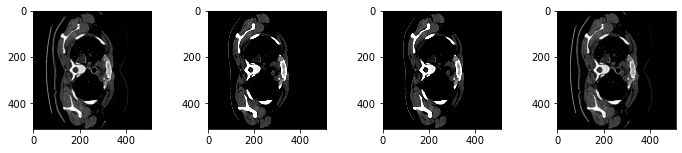

In [68]:
%matplotlib inline

img_path = os.path.join(directory, 'Dataset', 'TRN_0700.nii.gz')



slice = 100

image_vol = nib.load(img_path)
vol_arr = image_vol.get_fdata()

print(vol_arr.shape)

dims = (512, 512)

image_slice = vol_arr[:, :, slice] 

img1 = Image.fromarray(image_slice)
slice_resized1 = img1.resize(dims,
                            Image.BICUBIC
                            )

slice_resized2 = cv2.resize(image_slice, 
                           dims, 
                           interpolation=cv2.INTER_CUBIC)
# cv2.imshow(slice_resized)

slice_resized3 = cv2.resize(image_slice, 
                           dims, 
                           interpolation=cv2.INTER_LANCZOS4)

img2 = Image.fromarray(image_slice)
slice_resized4 = img1.resize(dims,
                            Image.LANCZOS)

figure = plt.figure(figsize=(12, 10))
ax1 = figure.add_subplot(4, 4, 1)
ax2 = figure.add_subplot(4, 4, 2)
ax3 = figure.add_subplot(4, 4, 3)
ax4 = figure.add_subplot(4, 4, 4)

ax1.imshow(slice_resized1, cmap='gray', vmin=0, vmax=255)
ax2.imshow(slice_resized2, cmap='gray', vmin=0, vmax=255)
ax3.imshow(slice_resized3, cmap='gray', vmin=0, vmax=255)
ax4.imshow(slice_resized4, cmap='gray', vmin=0, vmax=255)

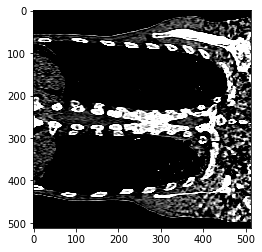

In [37]:
plt.imshow(slice_resized2, cmap='gray', vmin=0, vmax=255)
plt.show()

In [8]:
h = os.listdir(os.path.join(home, directory, 'Images'))

In [9]:
len(h)

184116

In [3]:
# df.count()

In [4]:
# df.TypeOfTB.value_counts()

In [7]:
base_path = os.path.join(home, directory)
base_dataset = os.path.join(base_path, 'Dataset')
base_processed = os.path.join(base_path, 'Images')

image_vol_list = os.listdir(base_dataset)
total_time = 0

for i, image in enumerate(image_vol_list):
    image_path = os.path.join(base_dataset, image)
    base_name = image.split('.')[0]
    
    image_vol = nib.load(image_path)
    vol_arr = image_vol.get_fdata()
    
    t0 = time.clock()
    for slice in range(150, 350+1):
        image_slice = vol_arr[slice, :, :]
        slice_resized = cv2.resize(image_slice, 
                                   (512, 512), 
                                   interpolation=cv2.INTER_NEAREST_EXACT)
        
        new_name = f'{base_name}_{slice}.png'
        save_path = os.path.join(base_processed, new_name)
        
        cv2.imwrite(save_path, slice_resized)
        
    total_time += time.clock() - t0
    print(f"""
    Processed: {base_name}
    Total Time Elapsed: {total_time}\n""")


/home/ayushman.singh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app



    Processed: TRN_0001
    Total Time Elapsed: 20.43



/home/ayushman.singh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
